In [1]:
import numpy as np

class ArpsModel:
    """
    A class containing the mathematical models for Arps' Decline Curve Analysis (DCA).
    
    Equations:
    - Hyperbolic: q(t) = q_i / (1 + b * D_i * t)^(1/b)
    - Exponential (b=0): q(t) = q_i * exp(-D_i * t)
    - Harmonic (b=1): q(t) = q_i / (1 + D_i * t)
    """

    @staticmethod
    def hyperbolic_decline(t, qi, Di, b):
        """
        Calculates the production rate (q) at time (t) using the Hyperbolic decline model.
        
        Args:
            t (array-like): Time steps (e.g., months, days).
            qi (float): Initial production rate.
            Di (float): Initial effective decline rate (fractional, e.g., 0.5 for 50%).
            b (float): Hyperbolic decline exponent (0 <= b <= 1 typically).
            
        Returns:
            numpy.ndarray: Production rate array at time t.
        """
        # Handle the Exponential case where b approaches zero
        if np.isclose(b, 0.0):
            return ArpsModel.exponential_decline(t, qi, Di)
        
        # Hyperbolic calculation
        q = qi / (np.power((1 + b * Di * t), (1.0 / b)))
        return q

    @staticmethod
    def exponential_decline(t, qi, Di):
        """
        Calculates the production rate (q) at time (t) using the Exponential decline model (b=0).
        """
        q = qi * np.exp(-Di * t)
        return q

    @staticmethod
    def harmonic_decline(t, qi, Di):
        """
        Calculates the production rate (q) at time (t) using the Harmonic decline model (b=1).
        """
        q = qi / (1 + Di * t)
        return q

# Example of how the model would be used in the optimizer module:
# time_steps = np.arange(0, 36) # 3 years in months
# forecasted_rate = ArpsModel.hyperbolic_decline(time_steps, 1000, 0.1, 0.5)

In [4]:
import sys
import os

# Add the parent directory (project root) to sys.path
#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
#from src.arps import ArpsModel

class ArpsOptimizer:
    """
    A class to handle the optimization and fitting of production data 
    to Arps' Decline Curve models.
    """

    def __init__(self, t, q):
        """
        Initialize with time and production rate data.
        
        Args:
            t (array-like): Time array (days or months).
            q (array-like): Production rate array.
        """
        # Ensure inputs are numpy arrays and handle potential NaNs
        self.t = np.array(t)
        self.q = np.array(q)
        
        # Basic data validation: Remove NaN or Inf values if present
        mask = np.isfinite(self.q) & np.isfinite(self.t)
        self.t = self.t[mask]
        self.q = self.q[mask]

    def fit_hyperbolic(self, b_min=0.0, b_max=1.0):
        """
        Fits the Hyperbolic Arps model to the data.
        
        Args:
            b_min (float): Minimum allowed b-factor (physics constraint).
            b_max (float): Maximum allowed b-factor (physics constraint).
                           Note: Unconventionals may require b_max up to 2.0.
        
        Returns:
            dict: Optimized parameters {'qi', 'Di', 'b'} and 'covariance_matrix'.
        """
        
        # 1. Define Initial Guesses (p0)
        # This helps the optimizer converge faster and avoids local minima.
        qi_guess = np.max(self.q)  # Start qi at the peak rate
        Di_guess = 0.5             # Start with a moderate decline (50%)
        b_guess = 0.5              # Start b exactly in the middle
        p0 = [qi_guess, Di_guess, b_guess]

        # 2. Define Bounds (Physics Constraints)
        # Structure: ([low_qi, low_Di, low_b], [high_qi, high_Di, high_b])
        # qi: Must be positive, max can be slightly higher than max data
        # Di: Must be positive, max usually < 100% (or 1.0) per step, but we allow up to 5.0 for safety
        lower_bounds = [0.0, 0.0, b_min]
        upper_bounds = [np.inf, 5.0, b_max]
        
        try:
            # 3. Perform the Curve Fit
            popt, pcov = curve_fit(
                ArpsModel.hyperbolic_decline, 
                self.t, 
                self.q, 
                p0=p0, 
                bounds=(lower_bounds, upper_bounds)
            )
            
            # Unpack optimal parameters
            qi_opt, Di_opt, b_opt = popt
            
            return {
                "qi": qi_opt,
                "Di": Di_opt,
                "b": b_opt,
                "success": True,
                "message": "Optimization successful"
            }

        except RuntimeError as e:
            # Handle cases where optimization fails to converge
            return {
                "success": False,
                "message": str(e),
                "qi": None, "Di": None, "b": None
            }

    def fit_exponential(self):
        """
        Fits the Exponential Arps model (b=0).
        Useful for comparison or conservative forecasting.
        """
        # Initial Guess
        qi_guess = np.max(self.q)
        Di_guess = 0.1
        p0 = [qi_guess, Di_guess]

        # Bounds: qi > 0, Di > 0
        lower_bounds = [0.0, 0.0]
        upper_bounds = [np.inf, 5.0]

        try:
            popt, pcov = curve_fit(
                ArpsModel.exponential_decline,
                self.t,
                self.q,
                p0=p0,
                bounds=(lower_bounds, upper_bounds)
            )
            qi_opt, Di_opt = popt
            
            return {
                "qi": qi_opt,
                "Di": Di_opt,
                "b": 0.0, # Explicitly 0 for exponential
                "success": True
            }
        except RuntimeError as e:
            return {"success": False, "message": str(e)}

Optimized Parameters: qi=990.38, Di=0.10, b=0.46


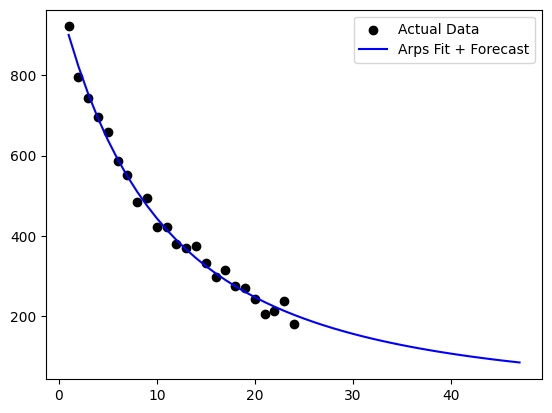

In [5]:
import numpy as np
#from src.optimization import ArpsOptimizer
#from src.arps import ArpsModel
import matplotlib.pyplot as plt

# 1. Simulate some data (or load from CSV)
t_data = np.arange(1, 25) # 24 months
q_data = 1000 / (1 + 0.5 * 0.1 * t_data)**(1/0.5) # Perfect hyperbolic data
# Add some noise (simulating real field data)
q_data_noisy = q_data + np.random.normal(0, 20, size=len(t_data))

# 2. Run the Optimizer
optimizer = ArpsOptimizer(t_data, q_data_noisy)
results = optimizer.fit_hyperbolic(b_min=0.0, b_max=1.0)

print(f"Optimized Parameters: qi={results['qi']:.2f}, Di={results['Di']:.2f}, b={results['b']:.2f}")

# 3. Generate the fitted curve for plotting
t_forecast = np.arange(1, 48) # Forecast out to 48 months
q_forecast = ArpsModel.hyperbolic_decline(t_forecast, results['qi'], results['Di'], results['b'])

# 4. Plot (This is what you'd put in your README)
plt.scatter(t_data, q_data_noisy, label='Actual Data', color='black')
plt.plot(t_forecast, q_forecast, label='Arps Fit + Forecast', color='blue')
plt.legend()
plt.show()